# Graph Neural network for prediction of Watts-Strogatz rewiring parameter
In this notebook we are going to implement a graph neural network to predict the rewiring paramenter of watts-strogatz graph using 1 dimensional Betti numbers a two step neighborhood of the nodes. We are then going to see the predicted rewiring probability on a the coma daset.

This notebook need is thought to be run on google colab

## Importing Watts-strogatz data
In this section we upload data of Watts-Strogatz 1 dimensional Betti numbers on the two-step neighborhood of a node.
First let us mount the clone the github repository with the data

In [96]:
!git clone https://github.com/SimoneChiominto/TDA_BrainNetworks.git

fatal: destination path 'TDA_BrainNetworks' already exists and is not an empty directory.


In [97]:
path='/content/TDA_BrainNetworks'
import sys
sys.path.append(path)

Let then upload the data via pickle

In [98]:
!pip3 install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
import pickle5 as pickle
import numpy as np

with open(path+"/data/ws_nbhd_betti","rb") as f:
    (betti_numbers_ws,corr_mats_ws,probs,thresholds)=pickle.load(f)

betti_numbers_ws=np.array(betti_numbers_ws)

## Installing pytorch-geometric
We then install pytorch-geometric which is the package we use to create our graph neural network

In [100]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

device = "cpu"

1.12.1+cu113


## GNN

In [101]:
! pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
from HomologyPackage import adjacency_matrix

sparsity=0.6
adj_mats_ws = [adjacency_matrix(mat,sparsity,method='sparsity_notconnected') for mat in corr_mats_ws]

In [103]:
k= len(adj_mats_ws)
rng=np.random.default_rng(12)
dataset=[]
features= []
feature_dimension = len(betti_numbers_ws[0][:,0])
feat=betti_numbers_ws

In [104]:
import networkx as nx
from torch_geometric.utils import from_networkx

dataset = [from_networkx(nx.from_numpy_array(i)) for i in adj_mats_ws]
features=(feat)

#matricione le cui righe sono i feature vector
features= [ar.transpose() for ar in features]

In [105]:
from torch_geometric.loader import DataLoader

In [106]:
complete_dataset=[]
train_dataset= []
test_dataset= []
lin_test = []
lin_train=[]  

    
#synthetic dataloading
for i in range(len(dataset)):
  complete_dataset.append(dataset[i])
  # len(complete_dataset)-1 si potrebbe mettere i a occhio, ci provo
  complete_dataset[i].x=torch.tensor([j for j in features[i]]).float() # [ [1],[2],...]
  complete_dataset[i].x.to(device)
  complete_dataset[i].y=torch.tensor([probs[i]]).float()
  complete_dataset[i].y.to(device)
  if (i % 5== 0):
    test_dataset.append(dataset[i])
    test_dataset[len(test_dataset)-1].x=torch.tensor([j for j in features[i]]).float() # [ [1],[2],...]
    test_dataset[len(test_dataset)-1].x.to(device)
    test_dataset[len(test_dataset)-1].y=torch.tensor([probs[i]]).float()
    test_dataset[len(test_dataset)-1].y.to(device)
    # lin dovrebbero essere delle prbabilità se ricordo bene
    lin_test.append(probs[i])# è stato modificato
  else:
    train_dataset.append(dataset[i])
    train_dataset[len(train_dataset)-1].x=torch.tensor([j for j in features[i]]).float()
    train_dataset[len(train_dataset)-1].x.to(device)
    train_dataset[len(train_dataset)-1].y=torch.tensor([probs[i]]).float()
    train_dataset[len(train_dataset)-1].y.to(device)
    lin_train.append(probs[i])
            

train_loader  = DataLoader(train_dataset,batch_size=1,shuffle=True)
test_loader  = DataLoader(test_dataset,batch_size=1,shuffle= True)
complete_loader = DataLoader(complete_dataset,batch_size=1,shuffle= False)
train_loader_plot  = DataLoader(train_dataset,batch_size=1,shuffle=False)
test_loader_plot  = DataLoader(test_dataset,batch_size=1,shuffle= False)

lin_test

[0.0,
 0.025252525252525256,
 0.05050505050505051,
 0.07575757575757576,
 0.10101010101010102,
 0.12626262626262627,
 0.15151515151515152,
 0.1767676767676768,
 0.20202020202020204,
 0.2272727272727273,
 0.25252525252525254,
 0.2777777777777778,
 0.30303030303030304,
 0.3282828282828283,
 0.3535353535353536,
 0.37878787878787884,
 0.4040404040404041,
 0.42929292929292934,
 0.4545454545454546,
 0.47979797979797983]

In [107]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import FeaStConv
from torch.nn import Linear

class GCN(torch.nn.Module):
  def __init__(self, embedding_dim):
    super(GCN, self).__init__()
    torch.manual_seed(12345)
    self.conv1 = GCNConv(feature_dimension, embedding_dim)
    self.conv2 = FeaStConv(embedding_dim, embedding_dim)
    '''
    self.conv3 = FeaStConv(embedding_dim, embedding_dim)
    self.conv4 = FeaStConv(embedding_dim, embedding_dim)
    '''
    '''
    self.conv5 = FeaStConv(embedding_dim, embedding_dim)
    self.conv6 = FeaStConv(embedding_dim, embedding_dim)
    self.conv7 = FeaStConv(embedding_dim, embedding_dim)
    '''
    
    self.linear = Linear(embedding_dim, 1)
    self.softmax = torch.nn.Softmax(1)
            
  def forward(self, x, edge_index, batch):
    #  produce the node embeddings via Graph Convolution
    x = self.conv1(x, edge_index)
    x = x.relu()
    #  aggregate the node embeddings to obtain a global one
    x = global_mean_pool(x, batch)  
    #  regularize and apply a final dense classifier
    # x = F.dropout(x, p=0 , training=self.training)#0,#0.9!
    x = self.linear(x)
    #x = self.softmax(x)
           
    return x

In [108]:
model = GCN(embedding_dim=200)#240, 120 è giusto    
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)#0.05
criterion = torch.nn.MSELoss()

In [109]:
ydataloss_train = []
ydataloss_test = []
out_test=[]

def train():
  model.train()
    
  for data1 in train_loader: 
             
    out = model(data1.x.to(device), data1.edge_index.to(device), data1.batch.to(device))  # Perform a single forward pass.
    loss = criterion(out.to(device), data1.y.to(device))  # Compute the loss.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad()  # Clear gradients.
  ydataloss_train.append(loss.item())

def test(loader):
  model.eval()
         
  correct = 0
         
  for data1 in loader:  
  #iterate in batches over both datasets
    out = model(data1.x.to(device), data1.edge_index.to(device), data1.batch.to(device)) 
             
    loss = criterion(out.to(device)[0], data1.y.to(device))

    correct += np.sqrt(abs(loss.item())  )
  # we can calculate the accuracy
  ydataloss_test.append((loss.item()))
  out_test.append(out.item())
  return correct/len(loader)

In [110]:
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt

xdata = []
ydatatest = []
ydatatrain = []
ydata = []

for epoch in range(1,70):#200
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)

  if(test_acc<=0.03):
    break
  print(f'Epoch: {epoch:03d}, Train err: {train_acc:.4f}, Test err: {test_acc:.4f}')
  xdata.append(epoch)
  ydatatest.append(test_acc)
  ydatatrain.append(train_acc)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train err: 0.1257, Test err: 0.1327
Epoch: 002, Train err: 0.0488, Test err: 0.0498
Epoch: 003, Train err: 0.0431, Test err: 0.0409
Epoch: 004, Train err: 0.0328, Test err: 0.0352
Epoch: 005, Train err: 0.0310, Test err: 0.0332
Epoch: 006, Train err: 0.0314, Test err: 0.0411


In [111]:
model.eval()
out_print= np.zeros(len(complete_loader))
y_print=np.zeros(len(complete_loader))
out_print_train =np.zeros(len(train_loader_plot))
out_print_test = np.zeros(len(test_loader_plot))

for i,graph in enumerate(complete_loader):
  out_print[i]=model(graph.x.to(device),graph.edge_index.to(device),graph.batch.to(device))
  y_print[i]=graph.y.to(device).item()
  #print(out_print[i])
            
for i,graph in enumerate(train_loader_plot):
  #print(graph)
  out_print_train[i]=model(graph.x.to(device),graph.edge_index.to(device),graph.batch.to(device))
        
for i,graph in enumerate(test_loader_plot):
  out_print_test[i]=model(graph.x.to(device),graph.edge_index.to(device),graph.batch.to(device))
    

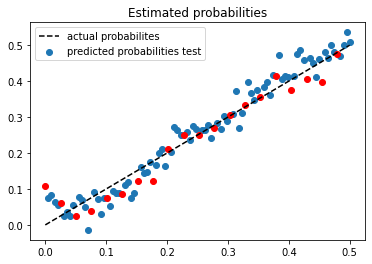

In [112]:
    plt.clf()

    plt.title("Estimated probabilities")
    
    #plt.scatter(probs,out_print)
    #plt.plot(probs,probs,color='red',linestyle='--')
    #plt.legend(['actual probabilites','predicted probabilities'])
    
    plt.scatter(lin_train,out_print_train)
    plt.plot(probs,probs,color='black',linestyle='--')
    plt.legend(['actual probabilites','predicted probabilities train'])
    
    plt.scatter(lin_test,out_print_test,color='red')
    #plt.plot(lin,y_print[1::2],color='black',linestyle='--')
    plt.legend(['actual probabilites','predicted probabilities test'])
       


## Test on Coma dataset

In [113]:
with open(path+"/data/patients_nbhd_betti","rb") as f:
    (betti_numbers_patients,patient_files,thresholds)=pickle.load(f)

with open(path+"/data/controls_nbhd_betti","rb") as f:
    (betti_numbers_controls,control_files,thresholds)=pickle.load(f)

betti_numbers_patients=np.array(betti_numbers_patients)
betti_numbers_controls=np.array(betti_numbers_controls)
feat_test = np.concatenate([betti_numbers_patients,betti_numbers_controls],axis=0)
k=len(feat_test)
feat_test=[ar.transpose() for ar in feat_test]

coma_path='/content/TDA_BrainNetworks/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization-main/DATA/cor_mat_coma'
coma_files=[coma_path+'/'+file_name for file_name in patient_files+control_files ]
corr_mats_coma=[np.loadtxt(file_name, usecols=range(1,91), skiprows=1, dtype='float') for file_name in coma_files]

adj_mats_coma = [adjacency_matrix(mat,sparsity,method='sparsity_notconnected') for mat in corr_mats_coma]


In [114]:
coma_dataset=[]
dataset_coma = [from_networkx(nx.from_numpy_array(i)) for i in adj_mats_coma]
    
#synthetic dataloading
for i in range(len(dataset_coma)):
  coma_dataset.append(dataset_coma[i])
  coma_dataset[i].x=torch.tensor([j for j in feat_test[i]]).float() # [ [1],[2],...]
  coma_dataset[i].x.to(device)
  coma_dataset[i].y=torch.tensor([probs[i]]).float()
  coma_dataset[i].y.to(device)

coma_dataset=DataLoader(coma_dataset,batch_size=1) 

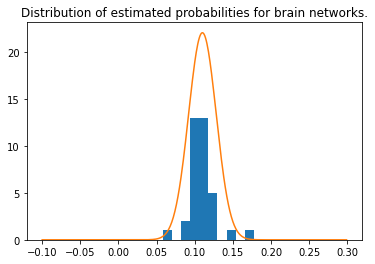

In [116]:
from scipy.stats import norm


result = []
for i,network in enumerate(coma_dataset):
  result.append(model(network.x.to(device),network.edge_index.to(device),network.batch.to(device)).cpu().detach().numpy().item())

plt.clf()
plt.title("Distribution of estimated probabilities for brain networks.")
    
plt.hist(result)
(mu, sigma) = norm.fit(result)
x_axis = np.arange(-0.1, 0.3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, mu, sigma))
